## Supernova distances and redshift

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 



In [123]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import uniform, norm, chi2
from scipy.interpolate import interp1d
from astroML.datasets import generate_mu_z
from astroML.resample import jackknife
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.utils import shuffle
import astropy.units as u
from astropy.cosmology import LambdaCDM
import emcee
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import corner
from IPython.display import display, Markdown

#Set global plot parameters
plt.rcParams["figure.figsize"] = (7, 7)

In [124]:
#Generate dataset

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)
z_ml = z_sample[:, np.newaxis]

Text(0, 0.5, '$\\mu$')

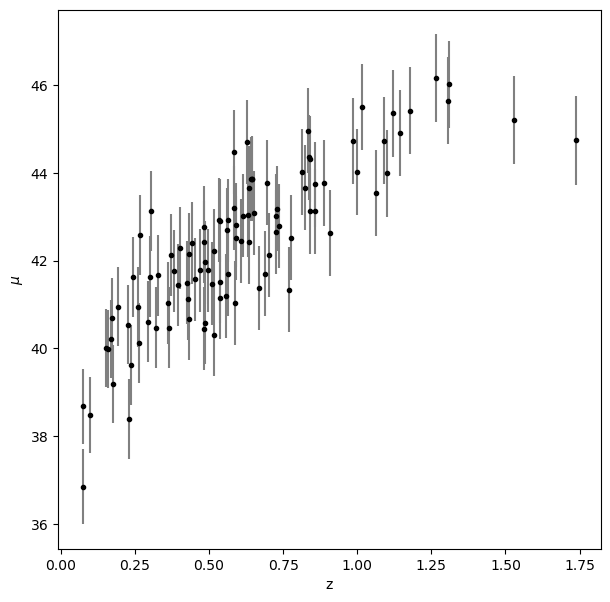

In [125]:
plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt=".k", ecolor="grey")
plt.xlabel("z")
plt.ylabel("$\mu$")

## Gaussian process regression

I implemented a manual CV because with GridSearchCV it's harder to insert the regularization parameter $\alpha$ of the GPR classifier

In [128]:
#K-fold cross validation

def CrossValidationGPR(X, y, y_err, kernel, K=10, metric="clf"):
    #Train and validation errors
    e_tr = []
    e_val = []

    #Separate data in K sets and train on K - 1 of them

    rkf = KFold(n_splits=K)
    
    for train, test in rkf.split(X, y):
        clf = GaussianProcessRegressor(kernel=kernel, alpha=y_err[train]**2, normalize_y=True)
        clf.fit(X[train], y[train])  

        if metric == "rms":
            e_tr.append(-np.sqrt(np.sum((y[train] - clf.predict(X[train]))**2) / len(X[train])))
            e_val.append(-np.sqrt(np.sum((y[test] - clf.predict(X[test]))**2) / len(X[test])))

        elif metric == "clf":
            e_tr.append(clf.score(X[train], y[train]))
            e_val.append(clf.score(X[test], y[test]))

    return np.mean(e_tr), np.mean(e_val)

In [129]:
#Kernel tuning

RBF_kernels = np.array([kernels.RBF(length_scale=i) for i in np.linspace(0.01, 20, 10)])
RatQuad_kernels = np.array([kernels.RationalQuadratic(length_scale=i, alpha_bounds=(1e-5, 1e50)) for i in np.linspace(1.0, 5.0, 10)])
Const_kernels = np.array([kernels.ConstantKernel(constant_value=i, constant_value_bounds=(1e-300, 1e5)) for i in np.linspace(1.0, 10.0, 10)])
RBF_C_kernels = []

#Construct kernels of the type "Const. * RBF"

for i in Const_kernels:
    for j in RBF_kernels:
        if np.where(RBF_kernels == j)[0] >= np.where(Const_kernels == i)[0]:    #Cycle through all combinations of Const. * RBF
            RBF_C_kernels.append(i * j)

RBF_C_kernels = np.array(RBF_C_kernels)

kernel_choice = np.concatenate([RBF_kernels, RatQuad_kernels, Const_kernels, RBF_C_kernels])

In [130]:
#Cross validation of the GPR kernel

e_tr_kernel, e_ts_kernel = np.array([CrossValidationGPR(z_ml, mu_sample, dmu**2, ker, 10) for ker in kernel_choice]).T
best_kernel = kernel_choice[np.argmax(e_ts_kernel)]
print("Best kernel: " + str(best_kernel))

Best kernel: 1**2 * RBF(length_scale=15.6)


In [131]:
#GPR fitting

z_grid = np.linspace(0.001, 1.2*max(z_sample), 100)

gpr = GaussianProcessRegressor(kernel=best_kernel, alpha=dmu**2)
gpr.fit(z_ml, mu_sample)
mu_fit, sigma_fit = gpr.predict(z_grid[:, np.newaxis], return_std=True)

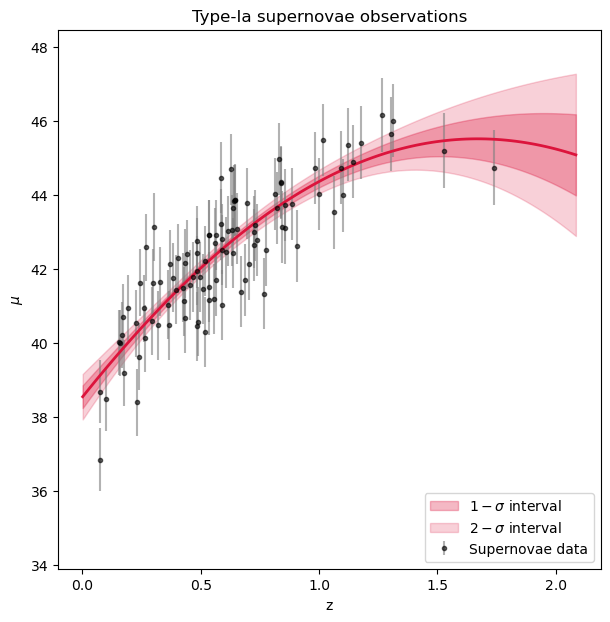

In [132]:
#Plot GPR fit

plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt=".k", ecolor="grey", alpha=0.6, label="Supernovae data")
plt.plot(z_grid, mu_fit, lw=2, color="crimson")
plt.fill_between(z_grid, mu_fit - sigma_fit, mu_fit + sigma_fit, color="crimson", alpha=0.3, label="$1-\sigma$ interval")
plt.fill_between(z_grid, mu_fit - 2*sigma_fit, mu_fit + 2*sigma_fit, color="crimson", alpha=0.2, label="$2-\sigma$ interval")
plt.title("Type-Ia supernovae observations")
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.ylim(0.92*min(mu_sample), 1.05*max(mu_sample))
plt.legend(loc="lower right")

# $\Lambda$CDM model fitting

In [134]:
#Distance modulus, likelihood, priors and posterior

def DistMod(H0, O_m, O_de, z):
    return LambdaCDM(H0=H0, Om0=O_m, Ode0=O_de).distmod(z).value


def logLikelihood(params, z, mu, sigma):
    H0, O_m = params
    
    if O_m < 0:
        return -np.inf
    
    mu_model = DistMod(H0, O_m, 1 - O_m, z)

    return np.sum(norm(mu_model, sigma).logpdf(mu))


def logPrior(params):
    H0, O_m = params
    prior_H0 = 1.
    prior_Om = 1.

    if 0 < H0 < 100 and 0 < O_m < 1:
        return np.log(prior_H0 * prior_Om)

    return -np.inf


def logPosterior(params, z, mu, sigma):
    return logLikelihood(params, z, mu, sigma) + logPrior(params)

## Frequentist approach

In [136]:
#Maximize likelihood

logL = lambda theta: -logLikelihood((theta[0], theta[1]), z_sample, mu_sample, dmu)
results = opt.fmin(logL, (70, 0.3), maxiter=3000)
H0, O_m = results

Optimization terminated successfully.
         Current function value: 132.813297
         Iterations: 39
         Function evaluations: 77


In [137]:
#Goodness of fit

chi2_model = np.sum(((mu_sample - DistMod(H0, O_m, 1 - O_m, z_sample)) / dmu)**2)
p_value = 1 - chi2(len(z_sample) - 2).cdf(chi2_model)
print("p-value = " + str(p_value))

p-value = 0.6302670981518023


In [138]:
#Jackknife and parameter uncertainty

#Function to use for jackknife
def GetParameters(data, par="H0"):
    par_distr = []

    for i in range(0, data.shape[0]):
        z = z_sample[data[i, :]]
        mu = mu_sample[data[i, :]]
        err = dmu[data[i, :]]
        
        logL = lambda theta: -logLikelihood((theta[0], theta[1]), z, mu, err)
        params = opt.fmin(logL, (70, 0.3), maxiter=3000, disp=False)
    
        if par == "H0":
            par_distr.append(params[0])
    
        else:
            par_distr.append(params[1])

    return np.array(par_distr)
    

H0_mean, H0_std, H0_distr = jackknife(z_sample, user_statistic=GetParameters, kwargs=dict(par="H0"), return_raw_distribution=True, pass_indices=True)
Om_mean, Om_std, Om_distr = jackknife(z_sample, user_statistic=GetParameters, kwargs=dict(par="Om"), return_raw_distribution=True, pass_indices=True)

Text(0.5, 0, '$\\Omega_m$')

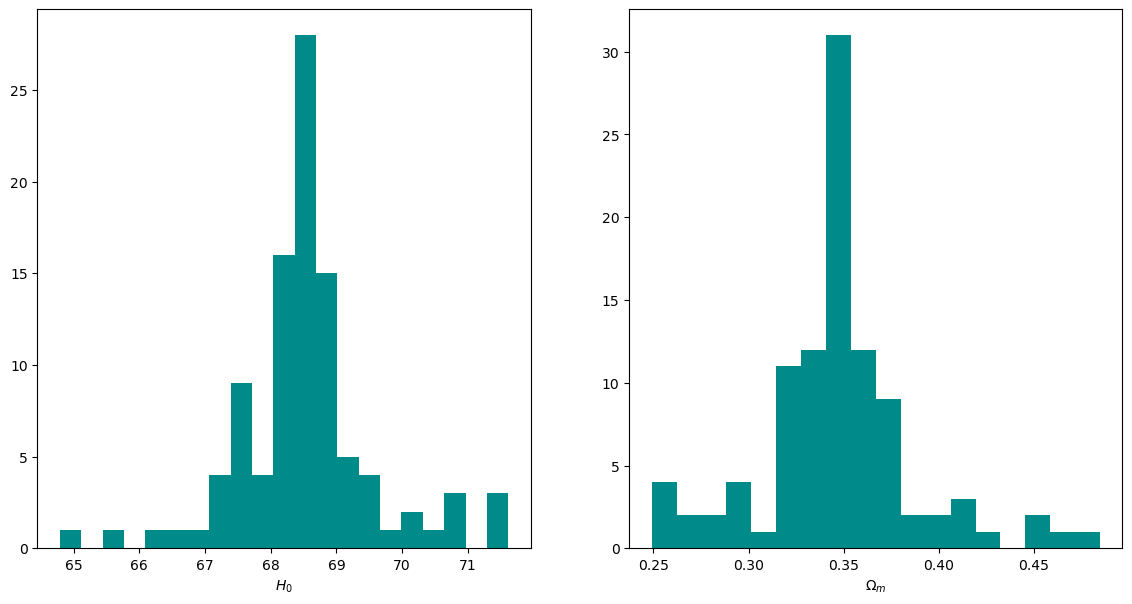

In [139]:
fig_jk, axes_jk = plt.subplots(1, 2, figsize=(14, 7))

#H0 jackknife distribution
axes_jk[0].hist(H0_distr, bins="fd", color="darkcyan")
axes_jk[0].set_xlabel("$H_0$")

#O_m jackknife distribution
axes_jk[1].hist(Om_distr, bins="fd", color="darkcyan")
axes_jk[1].set_xlabel("$\Omega_m$")

In [224]:
display(Markdown(
    "The bias-corrected jackknife estimates of the parameters are compatible with the MLE values but $\Omega_m$ seems a bit smaller:"
    "$$ H_0^J = " + f"{H0_mean:.2f}" + "\pm" + f"{H0_std:.2f}" + "$$"
    "$$\Omega_m^J = " + f"{Om_mean:.2f}" + "\pm" + f"{Om_std:.2f}" + "$$"
))

The bias-corrected jackknife estimates of the parameters are compatible with the MLE values but $\Omega_m$ seems a bit smaller:$$ H_0^J = 68.83\pm10.40$$$$\Omega_m^J = 0.20\pm0.40$$

The uncertainties on the parameters estimated through jackknife are quite large, probably because of the low number of points. Increasing the size of the dataset helps with decreasing them but increases computation time. Since I plot the model curve using the first values of $H_0$ and $\Omega_m$ found by MLE I use the standard deviation of the "raw" jackknife distributions as uncertainties, instead of the bias-corrected ones (which are instead associated to the bias-corrected mean).

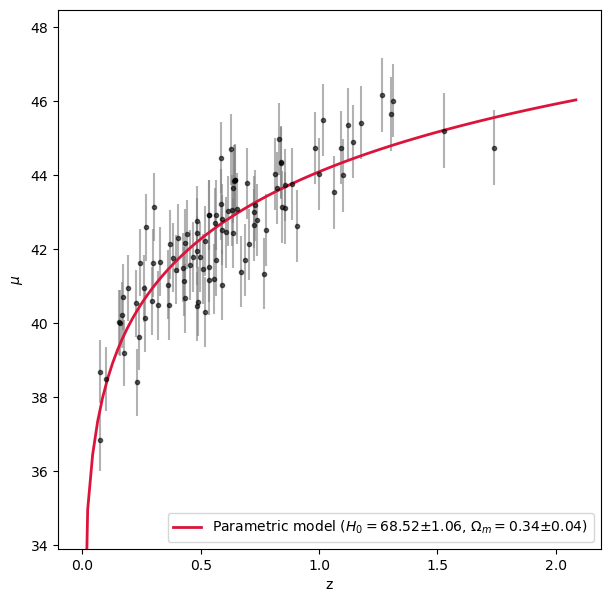

In [228]:
#Plot best fit

plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt=".k", ecolor="grey", alpha=0.6)
plt.plot(z_grid, DistMod(H0, O_m, 1 - O_m, z_grid), color="crimson", lw=2, 
         label="Parametric model ($H_0 = $" + f"{H0:.2f}" + "$\pm$" + f"{np.std(H0_distr):.2f}" + 
         ", $\Omega_m = $" + f"{O_m:.2f}" + "$\pm$" + f"{np.std(Om_distr):.2f}"")")
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.ylim(0.92*min(mu_sample), 1.05*max(mu_sample))
plt.legend(loc="lower right")

## Bayesian approach

### MCMC

In [145]:
#First try with emcee

n_dim = 2
n_walkers = 8
n_steps = 18000
start_point = np.random.random((n_walkers, n_dim)) + [70, 0.3]

sampler = emcee.EnsembleSampler(n_walkers, n_dim, logPosterior, args=[z_sample, mu_sample, dmu], threads=-1)
sampler.run_mcmc(start_point, n_steps, progress=True)

  0%|                                                                                        | 0/18000 [00:00<?, ?it/s]D:\anaconda3\envs\astroML\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████| 18000/18000 [04:28<00:00, 67.08it/s]


State([[68.00110271  0.63658648]
 [59.00036193  0.92875307]
 [72.18177888  0.22894044]
 [69.50344287  0.26553985]
 [76.77274981  0.19182677]
 [63.15325506  0.3536913 ]
 [67.38113715  0.49685136]
 [63.2055798   0.62712447]], log_prob=[-134.77564404 -133.44761435 -132.89999297 -132.90647386 -133.70070494
 -134.43605643 -133.16912302 -133.02816874], blobs=None, random_state=('MT19937', array([ 733669569, 2197020610,   75690423, 3594280707, 2765660658,
       2961198494,   49534237, 4269839941, 1501339272,  974182882,
       4139529361,  405180402, 3043405008, 2554930181, 3036079820,
       1668190295,   30629369, 3296207119,  905678477, 4162224556,
       4269848219,  138029030,  650150252, 3581066666, 3570593354,
        824458602, 3154642623, 2612535282, 2331400987,  529824278,
       1639954172, 3505036190, 2324980261,  497606883, 1195214954,
       2470180018, 2653100741, 2296369017, 1039085588, 1271551302,
       3821813725,  422084481,  787549186,  507406850,  594305139,
        196

Text(0, 0.5, '$\\Omega_m$')

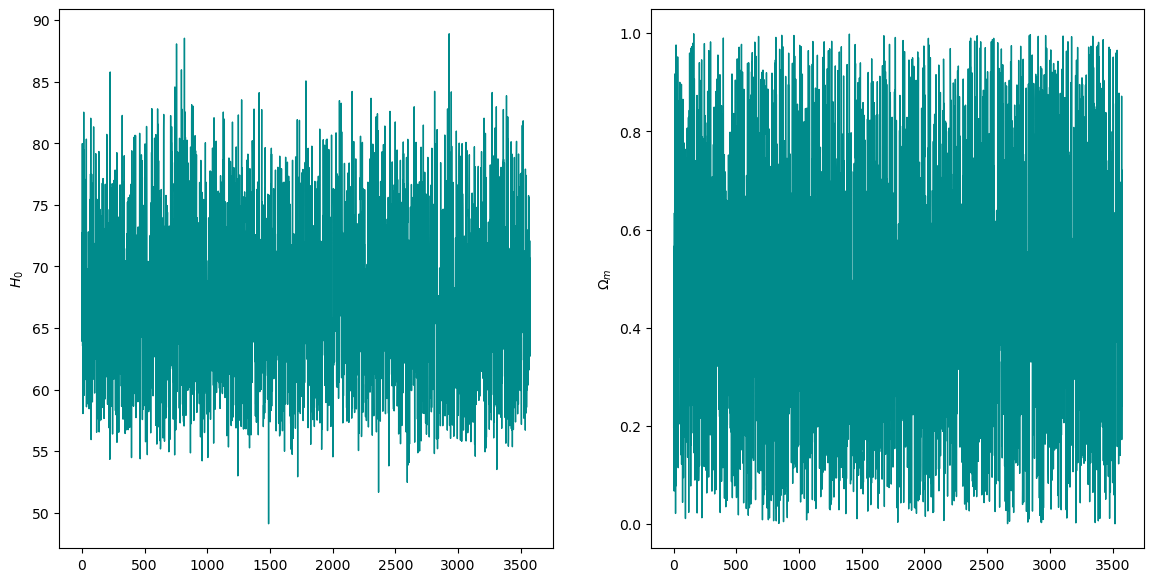

In [146]:
#Thinning and burn in

thin = int(max(sampler.get_autocorr_time()))
trace = sampler.get_chain(discard=100, thin=thin, flat=True)
x_grid = np.arange(0, len(trace[:, 0]))

fig, axis = plt.subplots(1, 2, figsize=(14, 7))
axis[0].plot(x_grid, trace[:, 0], lw=1, color="darkcyan")
axis[0].set_ylabel("$H_0$")
axis[1].plot(x_grid, trace[:, 1], lw=1, color="darkcyan")
axis[1].set_ylabel("$\Omega_m$")

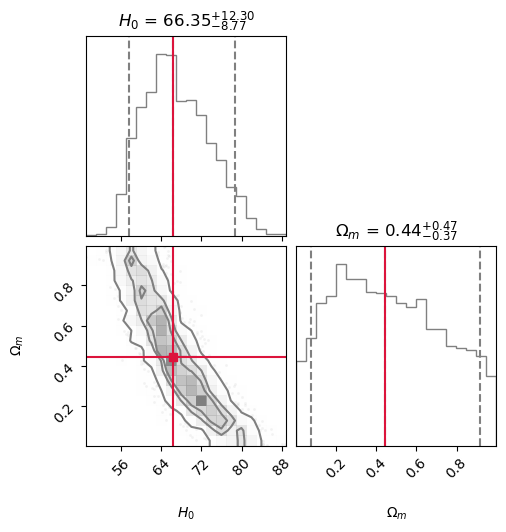

In [147]:
#Medians
medians = np.array([np.median(trace[:, i]) for i in range(0, n_dim)])

#Cornerplot

fig_corner = corner.corner(trace, labels=["$H_0$", "$\Omega_m$"], show_titles=True, quantiles=[0.05, 0.50, 0.95], levels=[0.39, 0.68, 0.95], color="grey", truths=medians, truth_color="crimson")
axes = np.array(fig_corner.axes).reshape((n_dim, n_dim))

### Nested sampling

In [149]:
#Second try with nested sampling

def PriorTransform(u):
    return np.array([uniform(0, 100).ppf(u[0]), uniform(0, 1).ppf(u[1])])

sampler_nest = dynesty.NestedSampler(logLikelihood, PriorTransform, n_dim, logl_args=[z_sample, mu_sample, dmu])
sampler_nest.run_nested()

1870it [01:08, 27.43it/s, +500 | bound: 1 | nc: 1 | ncall: 18186 | eff(%): 13.400 | loglstar:   -inf < -132.813 <    inf | logz: -135.692 +/-  0.055 | dlogz:  0.001 >  0.509]


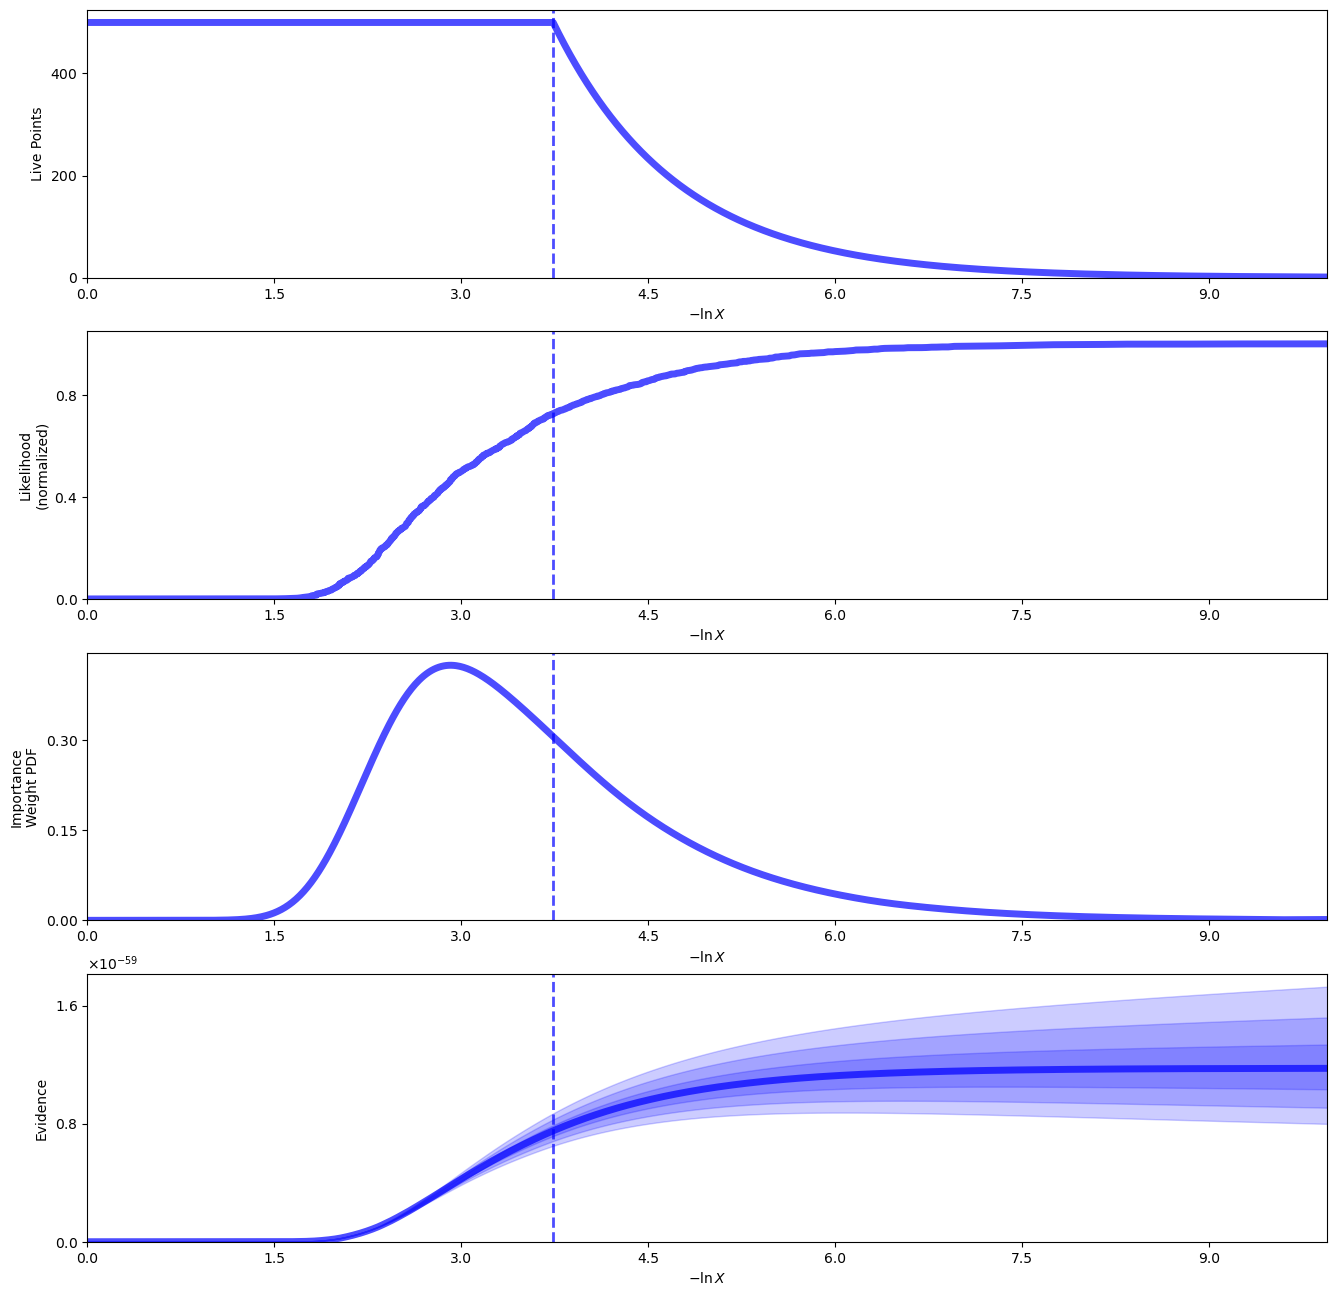

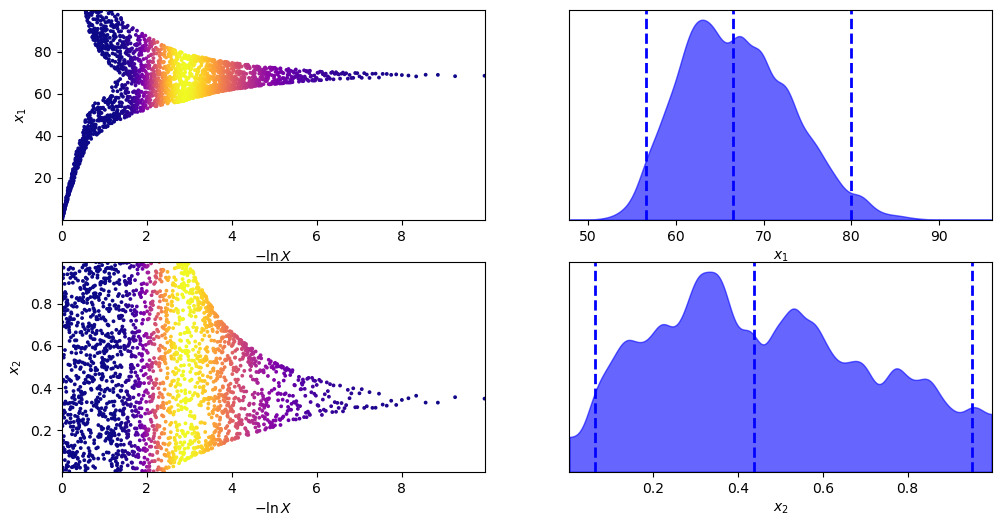

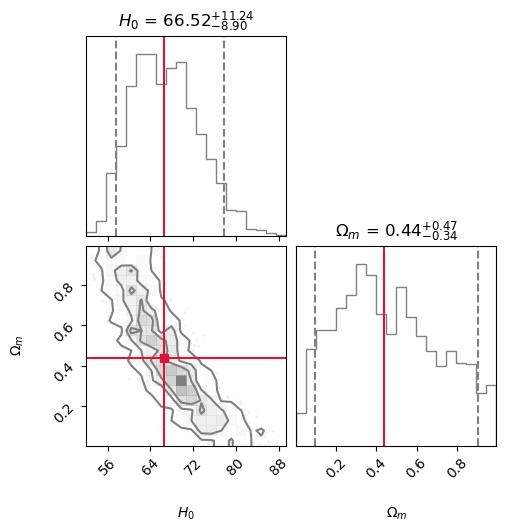

In [150]:
#Get trace
res = sampler_nest.results
samples_nest = res.samples
w_nest = np.exp(res.logwt - res.logz[-1])
samples_eq = dyfunc.resample_equal(samples_nest, w_nest)
mean, cov_nest = dyfunc.mean_and_cov(samples_nest, w_nest)

dyplot.runplot(res)
dyplot.traceplot(res)

#Medians
medians_n = np.array([np.median(samples_eq[:, i]) for i in range(0, n_dim)])
# regions_90_n = np.array([corner.quantile(samples_eq[:, i], [0.05, 0.95]) for i in range(0, n_dim)])

#Cornerplot

fig_corner_n = corner.corner(samples_eq, show_titles=True, labels=["$H_0$", "$\Omega_m$"], quantiles=[0.05, 0.50, 0.95], levels=[0.39, 0.68, 0.95], color="grey",  truths=medians_n, truth_color="crimson")
axes_n = np.array(fig_corner_n.axes).reshape((n_dim, n_dim))

(33.89919952301963, 48.47218559161017)

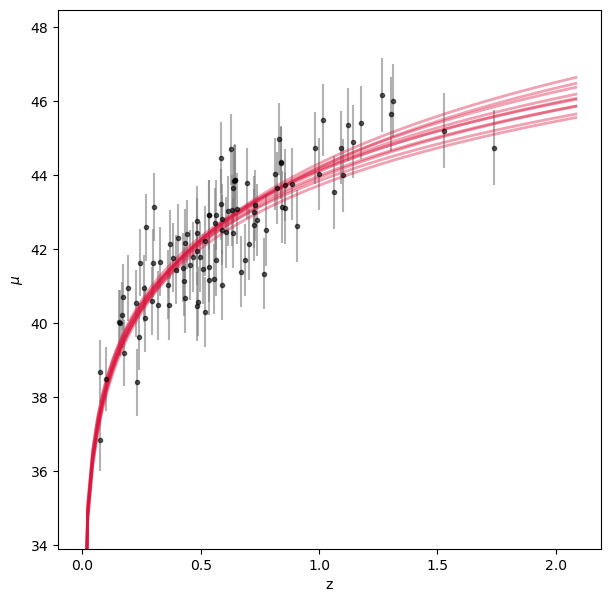

In [151]:
#Posterior spread of solutions

plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt=".k", ecolor="grey", alpha=0.6)

for i in samples_eq[::int(len(samples_eq)/10)]:
    plt.plot(z_grid, DistMod(i[0], i[1], 1 - i[1], z_grid), color="crimson", alpha=0.4, lw=2)

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.ylim(0.92*min(mu_sample), 1.05*max(mu_sample))

# Model without dark energy

In [153]:
def logLikelihoodNoDE(H0, z, mu, sigma): 
    dist_mod = LambdaCDM(H0=H0[0], Om0=1, Ode0=0).distmod(z).value

    return np.sum(norm(loc=dist_mod, scale=sigma).logpdf(mu))


#For nested sampling
def PriorTransform(u):
    return uniform(0, 100).ppf(u)

## Frequentist approach

In [155]:
#Maximize likelihood

logL = lambda theta: -logLikelihoodNoDE(theta, z_sample, mu_sample, dmu)
best_params_nodm = opt.fmin(logL, 70, maxiter=3000)
H0_NoDE = best_params_nodm[0]

Optimization terminated successfully.
         Current function value: 133.530368
         Iterations: 20
         Function evaluations: 40


In [156]:
#Goodness of fit

chi2_NoDE = np.sum(((mu_sample - LambdaCDM(H0=H0, Om0=1, Ode0=0).distmod(z_sample).value) / dmu)**2)
p_value_NoDE = 1 - chi2(len(z_sample) - 1).cdf(chi2_NoDE)
print("p-value = " + str(p_value_NoDE))

p-value = 0.21006591823999377


In [157]:
#Jackknife and parameter uncertainty

def GetParametersNoDE(data):
    par_distr = []

    for i in range(0, data.shape[0]):
        z = z_sample[data[i, :]]
        mu = mu_sample[data[i, :]]
        err = dmu[data[i, :]]
        
        logL = lambda theta: -logLikelihoodNoDE(theta, z, mu, err)
        params = opt.fmin(logL, 70, maxiter=3000, disp=False)

        par_distr.append(params[0])

    return np.array(par_distr)

       
H0_mean_NoDE, H0_std_NoDE, H0_distr_NoDE = jackknife(z_sample, user_statistic=GetParametersNoDE, return_raw_distribution=True, pass_indices=True)

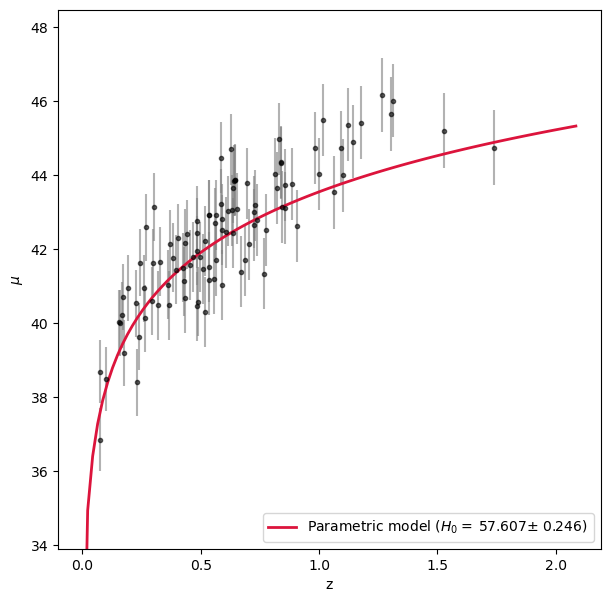

In [233]:
#Plot best fit

plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt=".k", ecolor="grey", alpha=0.6)
plt.plot(z_grid, LambdaCDM(H0=H0, Om0=1, Ode0=0).distmod(z_grid).value, color="crimson", lw=2, 
         label="Parametric model ($H_0 = $" + f"{H0_NoDE: .3f}" + "$\pm$" + f"{np.std(H0_distr_NoDE): .3f}" + ")")
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.ylim(0.92*min(mu_sample), 1.05*max(mu_sample))
plt.legend(loc="lower right")

## Nested sampling

In [160]:
sampler_de = dynesty.NestedSampler(logLikelihoodNoDE, PriorTransform, ndim=1, logl_args=[z_sample, mu_sample, dmu])
sampler_de.run_nested()

1881it [00:49, 38.00it/s, +500 | bound: 1 | nc: 1 | ncall: 19106 | eff(%): 12.797 | loglstar:   -inf < -133.530 <    inf | logz: -136.389 +/-  0.051 | dlogz:  0.001 >  0.509]


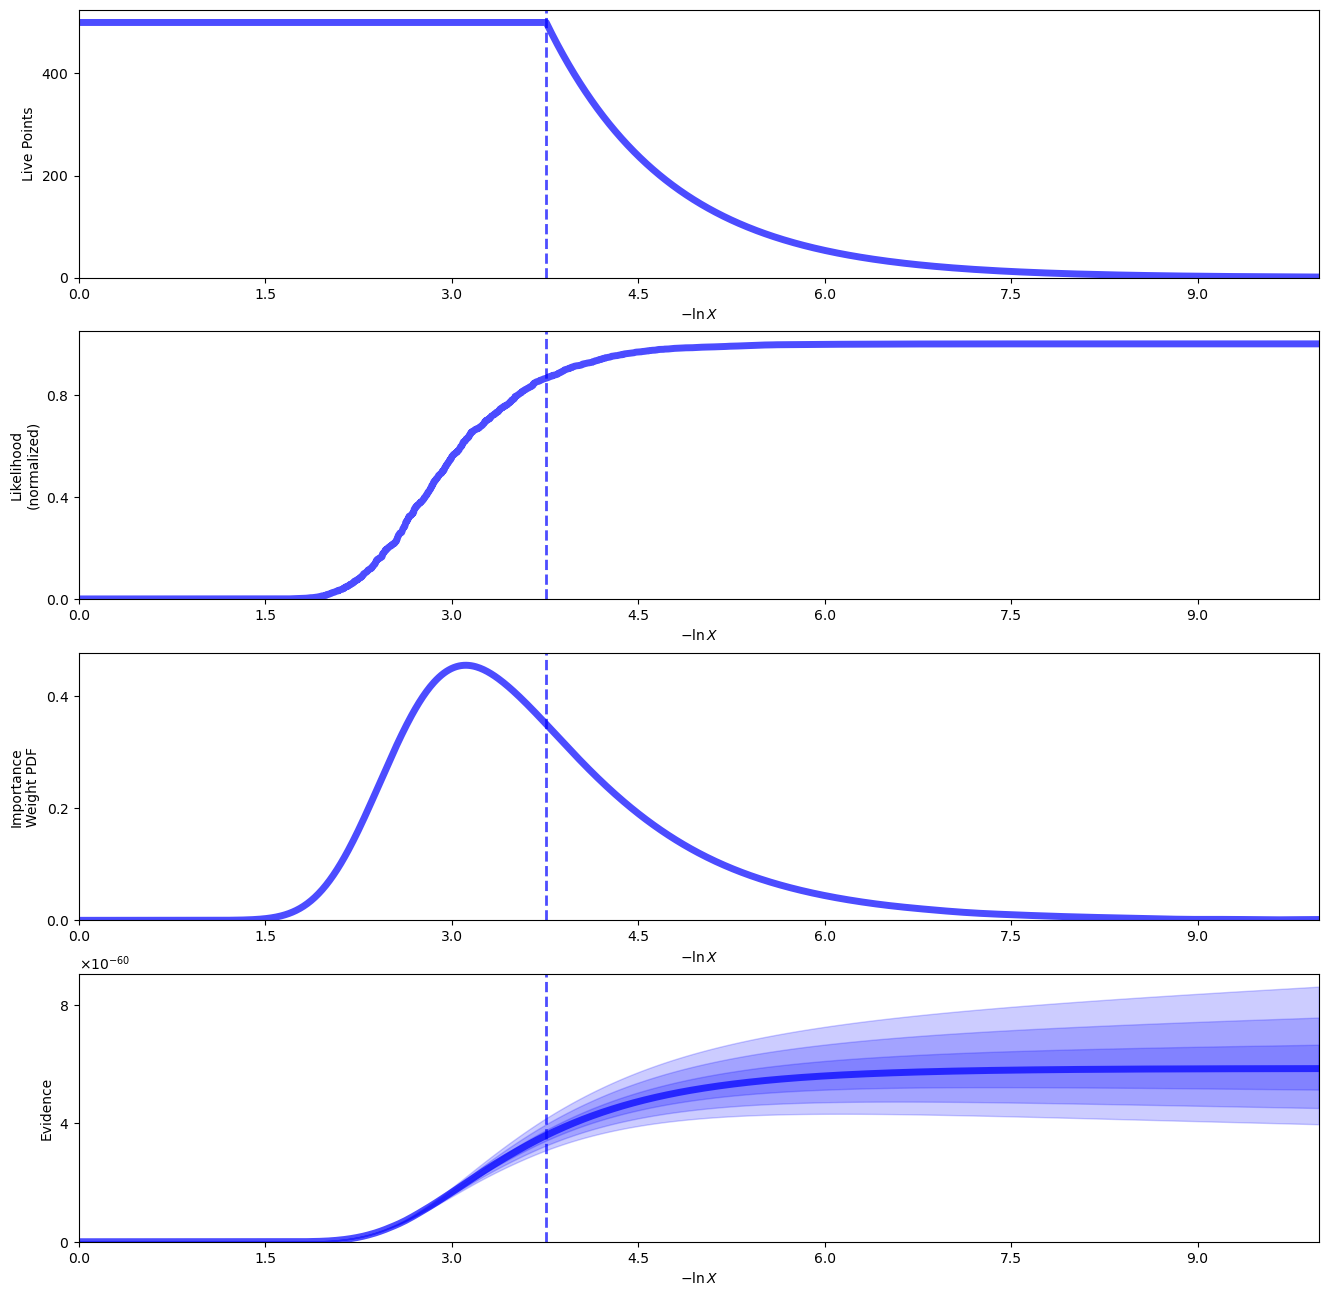

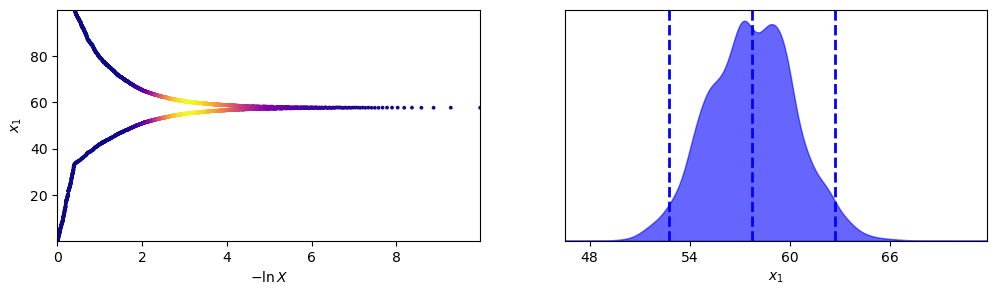

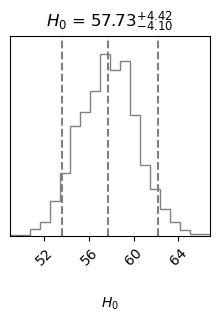

In [161]:
res_de = sampler_de.results
samples_de = res_de.samples
w_de = np.exp(res_de.logwt - res_de.logz[-1])
samples_eq_de = dyfunc.resample_equal(samples_de, w_de)
mean_de, cov_de = dyfunc.mean_and_cov(samples_de, w_de)

dyplot.runplot(res_de)
dyplot.traceplot(res_de)

fig_de = corner.corner(samples_eq_de, labels=["$H_0$"], show_titles=True, quantiles=[0.05, 0.50, 0.95], color="grey")

(33.89919952301963, 48.47218559161017)

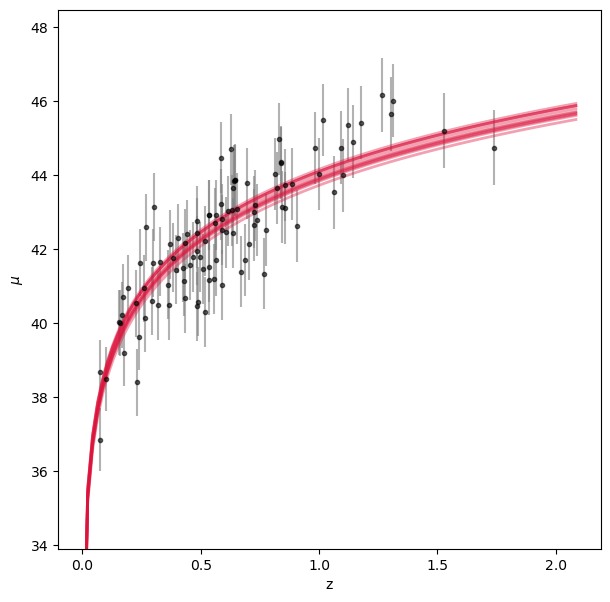

In [162]:
#Posterior spread of solutions

plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt=".k", ecolor="grey", alpha=0.6)

for i in samples_eq_de[::int(len(samples_eq_de)/10)]:
    plt.plot(z_grid, DistMod(i[0], 1, 0, z_grid), color="crimson", alpha=0.4, lw=2)

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.ylim(0.92*min(mu_sample), 1.05*max(mu_sample))

In [235]:
#Compute evidence for model with and without dark energy

flat_de_evidence = np.exp(res.logz[-1])
flat_no_de_evidence = np.exp(res_de.logz[-1])
logO_21 = np.log(flat_no_de_evidence / flat_de_evidence)

print("log(O21) = " + str(logO_21))

log(O21) = -0.6967827592038134


Evidence for no dark energy is $\textbf{"barely worth mentioning"}$.

## Dataset cloning

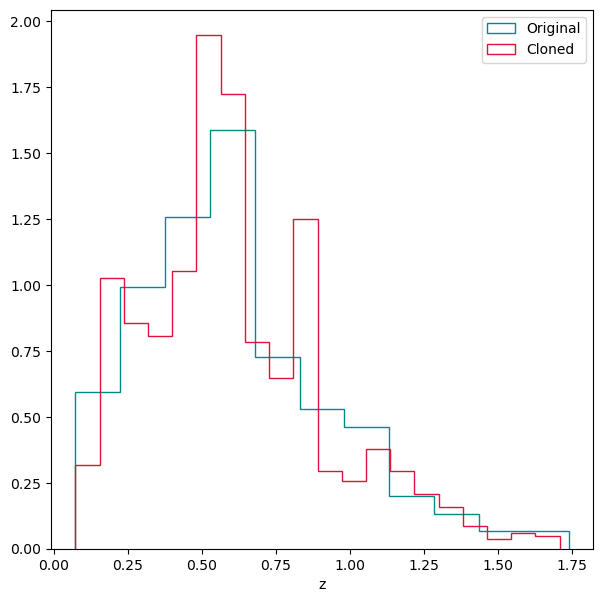

In [166]:
#Sample the redshift distribution to use in cloning (with inverse transform sampling)

e_cdf = [len(np.where(z_sample < z)[0]) / len(z_sample) for z in np.sort(z_sample)]
inv_cdf = interp1d(e_cdf, np.sort(z_sample))
unif = np.random.uniform(min(e_cdf), max(e_cdf), 1000)
z_clone = inv_cdf(unif)

#Plot the redshift distribution

plt.figure()
plt.hist(z_sample, bins="fd", color="darkcyan", histtype="step", label="Original", density=True)
plt.hist(z_clone, bins="fd", color="crimson", histtype="step", label="Cloned", density=True)
plt.xlabel("z")
plt.legend()

In [167]:
#Sample from GPR
mu_gpr = np.array([np.random.normal(loc=m, scale=s) for (m, s) in np.array(gpr.predict(z_clone[:, np.newaxis], return_std=True)).T])

#Sample from nested sampling
nest_samp = samples_eq[np.random.choice(np.arange(0, samples_eq.shape[0]), 1000)]
mu_nested = np.array([DistMod(h, o, 1 - o, z_clone[i]) for i, (h, o) in enumerate(nest_samp)])

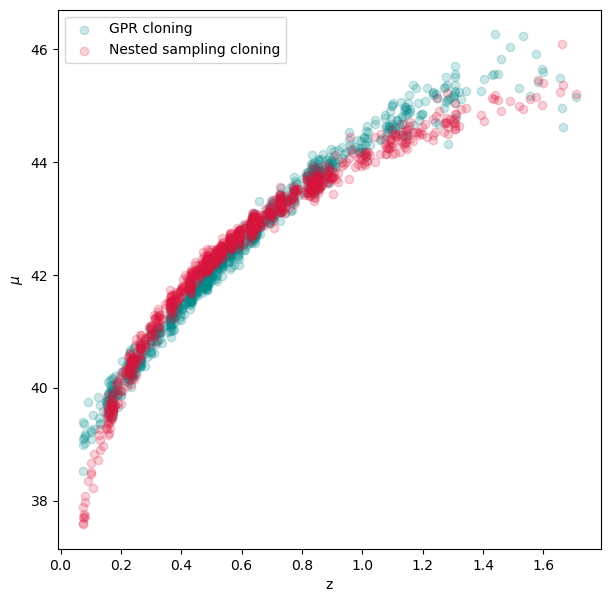

In [168]:
plt.figure()
plt.scatter(z_clone, mu_gpr, color="darkcyan", alpha=0.2, label="GPR cloning")
plt.scatter(z_clone, mu_nested, color="crimson", alpha=0.2, label="Nested sampling cloning")
plt.xlabel("z")
plt.ylabel("$\\mu$")
plt.legend()